## Unified API: Train and evaluation

This notebook presents the solution for using an unified API for the models(GANITE and CMGP).

First, make sure that all the depends are installed.
```
pip install -r requirements.txt
pip install .
```

Second, make sure the kernel you are using in this notebook is the same as the one with the library installed.

### Setup

First, we import all the dependencies necessary for the task.

In [1]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)

# Import depends
from ite.algs.model import Model # the unified API
import ite.datasets as ds

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import tabulate


/home/bcebere/anaconda3/envs/cambridge/bin/python
Instructions for updating:
non-resource variables are not supported in the long term


### Load the Dataset

For CGMP, we have to downsample to 1000 training items.
For the rest, we load without downsampling.

In [2]:
train_ratio = 0.8
 
full_dataloader = ds.load("twins", train_ratio)
cmgp_dataloader = ds.load("twins", train_ratio, downsample=1000)

## Load and train GANITE(Tensorflow version)

100%|██████████| 10000/10000 [00:07<00:00, 1382.65it/s]


Counterfactual Block:
 - Discriminator loss: 0.743 +/- 0.120
 - Generator loss: -1.413 +/- 0.128
ITE Block:
 - Loss: 0.299 +/- 0.083
ITE Block in-sample metrics:
 - sqrt_PEHE: 0.296 +/- 0.004
 - ATE: 0.020 +/- 0.004
ITE Block out-sample metrics:
 - sqrt_PEHE: 0.297 +/- 0.004
 - ATE: 0.026 +/- 0.004


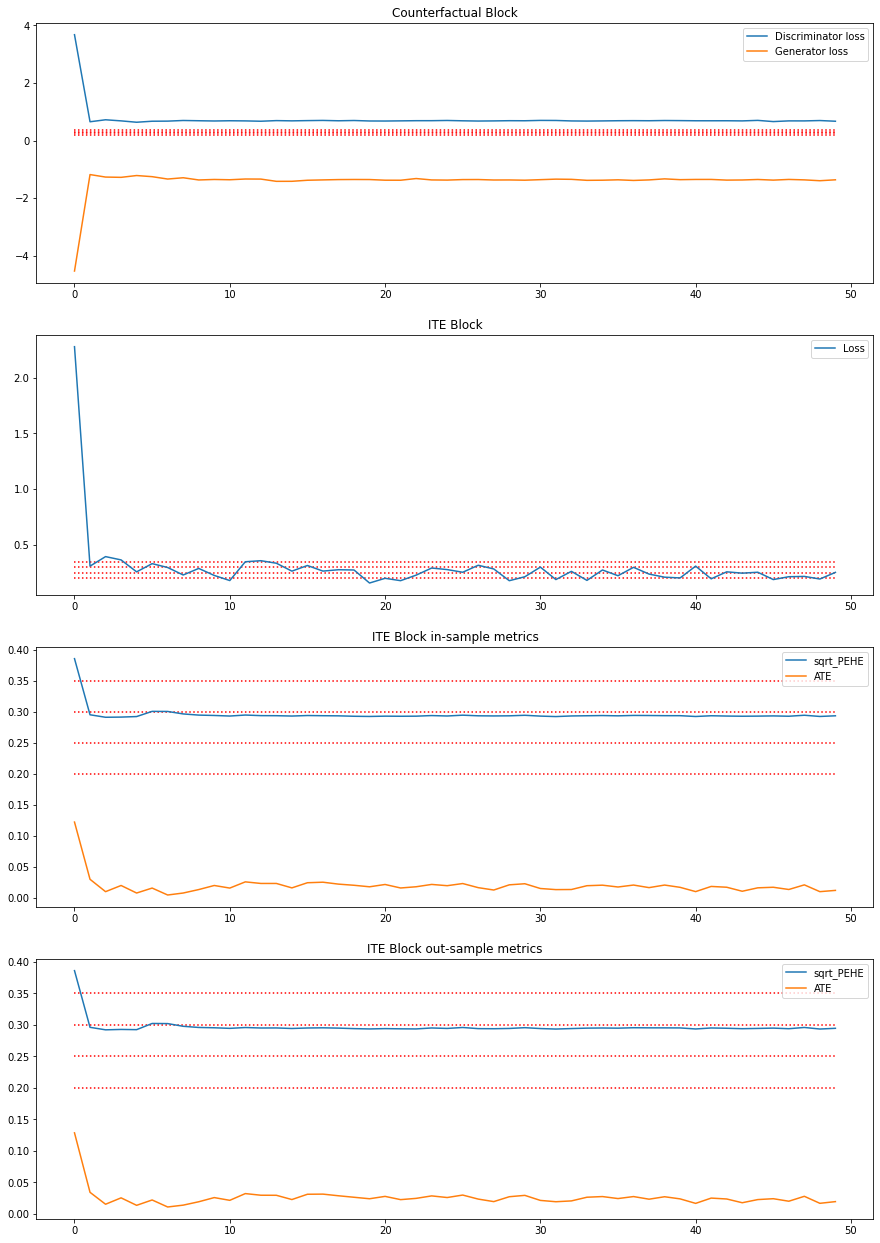

In [3]:
dim = len(full_dataloader[0][0])
dim_hidden = 8
dim_outcome = full_dataloader[-1].shape[1]
 
ganite_model = Model(
    "GANITE",
    dim, # number of features
    dim_hidden, # size of the hidden layers
    dim_outcome, # size of the output
    num_iterations=10000, # (optional)number of training iterations
    alpha=2, # (optional)alpha hyperparameter, used for the Generator block loss
    beta=2, # (optional)beta hyperparameter, used for the ITE block loss
    minibatch_size=128, # (optional)data batch size
    num_discr_iterations=10, # (optional)number of iterations executed by the discriminator.
)

metrics = ganite_model.train(*full_dataloader)
metrics.print()

metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

## Load and train GANITE(PyTorch version)

100%|██████████| 2000/2000 [00:05<00:00, 341.37it/s]


Counterfactual Block:
 - Discriminator loss: 0.450 +/- 0.088
 - Generator loss: -0.773 +/- 0.147
ITE Block:
 - ITE loss: 0.271 +/- 0.166
ITE Block in-sample metrics:
 - sqrt_PEHE: 0.311 +/- 0.003
 - ATE: 0.092 +/- 0.006
ITE Block out-sample metrics:
 - sqrt_PEHE: 0.311 +/- 0.003
 - ATE: 0.087 +/- 0.008


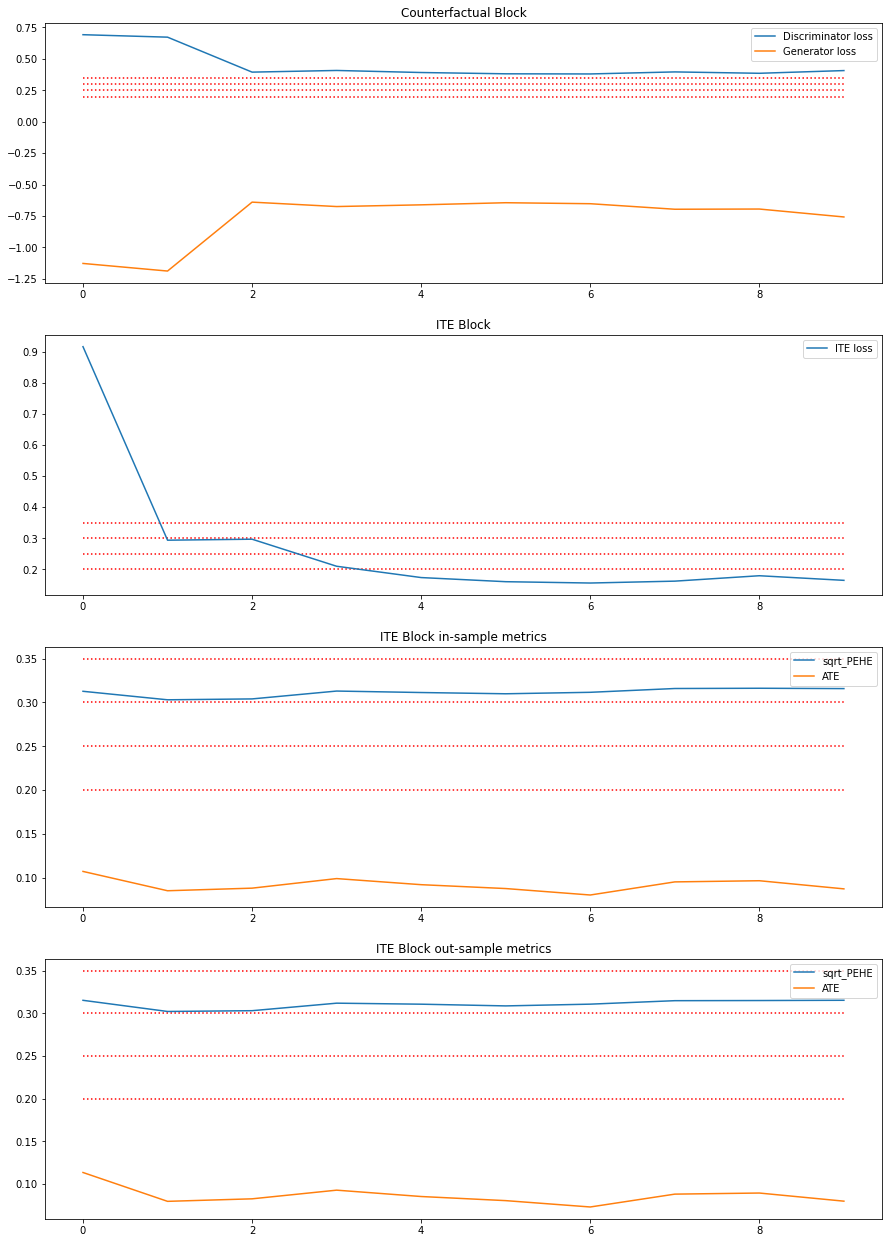

In [4]:
ganite_torch_model = Model(
    "GANITE_TORCH",
    dim, # number of features
    dim_hidden, # size of the hidden layers
    dim_outcome, # size of the output
    num_iterations=2000, # (optional)number of training iterations()
    alpha=2, # (optional)alpha hyperparameter, used for the Generator block loss
    beta=2, # (optional)beta hyperparameter, used for the ITE block loss
    minibatch_size=128, # (optional)data batch size
    num_discr_iterations=5, # (optional)number of iterations executed by the discriminator.
)

metrics = ganite_torch_model.train(*full_dataloader)
metrics.print()

metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

## Load and train CMGP

in-sample metrics:
 - sqrt_PEHE: 0.289 +/- 0.016
 - ATE: 0.007 +/- 0.018
out-sample metrics:
 - sqrt_PEHE: 0.290 +/- 0.038
 - ATE: 0.017 +/- 0.015


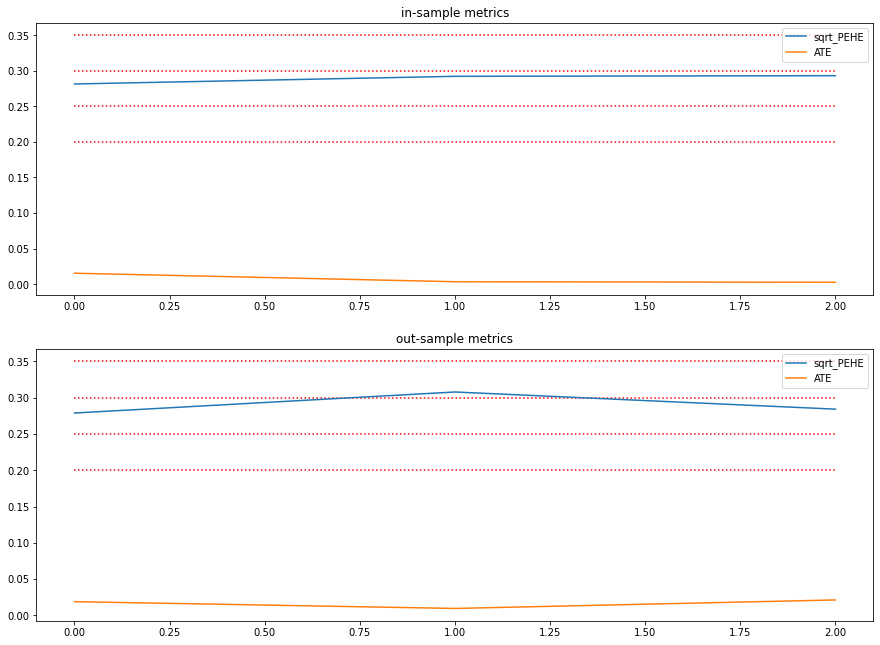

In [5]:
cmgp_model = Model(
    "CMGP",
    dim=dim,
    dim_outcome=dim_outcome,
    max_gp_iterations=1000, # (optional) Maximum number of interations for the Gaussian Process
)

for experiment in range(3):
    cmgp_dataloader = ds.load("twins", train_ratio, downsample=1000)
    metrics = cmgp_model.train(*cmgp_dataloader)

metrics.print()

metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

### Evaluate the models on the test set

In [6]:
[_, _, _, _, Test_X, Test_Y] = full_dataloader

ganite_test_metrics = ganite_model.test(Test_X, Test_Y)
ganite_torch_test_metrics = ganite_torch_model.test(Test_X, Test_Y)

[_, _, _, _, Test_X, Test_Y] = cmgp_dataloader
cmgp_test_metrics = cmgp_model.test(Test_X, Test_Y)

test_results = [
    ["Model", "sqrt_PEHE", "ATE"],
    ["GANITE", ganite_test_metrics.sqrt_PEHE(), ganite_test_metrics.ATE()],
    ["GANITE_TORCH", ganite_torch_test_metrics.sqrt_PEHE(), ganite_torch_test_metrics.ATE()],
    ["CMGP", cmgp_test_metrics.sqrt_PEHE(), cmgp_test_metrics.ATE()],
]

display(HTML(tabulate.tabulate(test_results, tablefmt='html')))

Model,sqrt_PEHE,ATE
GANITE,0.2946940451068641,0.02228852746761553
GANITE_TORCH,0.3161915742853347,0.08018842326723821
CMGP,0.2924423781547404,0.003919020547388836
